In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, dendrogram
import networkx as nx
from networkx.algorithms.community import girvan_newman
import enchant
import itertools
import random
from matplotlib import cm
import matplotlib.colors as mcolors

In [2]:
def clean_message(message):
    message = message.strip().split(" ")
    message = [word for word in message if word]  # Remove empty strings
    message = [''.join(char for char in word if char.isalnum()).lower() for word in message]
    message = [word for word in message if word]  # Remove empty strings again after cleaning
    return ' '.join(message)

In [5]:
def df_preprocessing(df):
    words = {}
    englishDictionary = enchant.Dict("en_GB")
    slangThreshold = 5

    df['body'] = df['body'].apply(clean_message)
    for message in df['body']:
        messageCopy = clean_message(message).split(" ")
        for word in messageCopy:
            word = ''.join(char for char in word if char.isalnum()).lower()
            if word:
                if word in words.keys():
                    words[word] += 1
                else:
                    words[word] = 1
                    
    print(len(words))

    wordsToRemove = []
    for word in list(words.keys()):
        if words[word] < slangThreshold:
            if not englishDictionary.check(word):
                wordsToRemove.append(word)
                
    for word in wordsToRemove:
        # print('Removing ' + word)
        del words[word]
        df['body'] = df['body'].str.replace(r'\b' + word + r'\b', '', regex=True)
                
    print(len(words))
    return df, words

In [7]:
def create_adj_matrix(df, words):
    adj_matrix = pd.DataFrame(np.zeros((len(words), len(words)), dtype=int), index=words.keys(), columns=words.keys())

    for message in df['body']:
        messageCopy = clean_message(message).split(" ")
        # print(messageCopy)
        for word1 in messageCopy:
            word1 = ''.join(char for char in word1 if char.isalnum()).lower()
            if word1 and word1 in words.keys():
                for word2 in messageCopy:
                    word2 = ''.join(char for char in word2 if char.isalnum()).lower()
                    if word2 and word2 in words.keys():
                        adj_matrix.at[word1, word2] += 1 
                        
    return adj_matrix

In [24]:

# help(enchant)
df = pd.read_csv('messages.csv')
df_me = df[df['is_from_me'] == 1].copy()
df_them = df[df['is_from_me'] == 0].copy()

df_me, words_me = df_preprocessing(df_me)
df_them, words_them = df_preprocessing(df_them)
df_combined, words_combined = df_preprocessing(df)

adj_matrix_me = create_adj_matrix(df_me, words_me)
adj_matrix_them = create_adj_matrix(df_them, words_them)
adj_matrix_combined = create_adj_matrix(df_combined, words_combined)

# print(adj_matrix_me)
# print(adj_matrix_them)

2835
2165
5413
3980
6357
4571


In [98]:
def adj_matrix_heatmap(adj_matrix):
    # Plot the adjacency matrix
    plt.figure(figsize=(5, 5))
    plt.title("Adjacency Matrix of Words")
    plt.xlabel("Words")
    plt.ylabel("Words")
    sns.heatmap(adj_matrix, annot=False, fmt="d", cmap='viridis', cbar_kws={'ticks': range(adj_matrix.values.max() + 1)})

    plt.xticks([])
    plt.yticks([])
    plt.show()

In [18]:
def layered_layout(G, root):
    pos = {}
    layers = nx.single_source_shortest_path_length(G, root)  # Get shortest paths
    max_layer = max(layers.values())
    
    # Group nodes by layer
    layer_nodes = {i: [] for i in range(max_layer + 1)}
    for node, layer in layers.items():
        layer_nodes[layer].append(node)
    
    # Calculate positions
    for layer, nodes in layer_nodes.items():
        num_nodes = len(nodes)
        if num_nodes > 0:
            np.random.shuffle(nodes)
            # Central alignment for x-axis
            x_spacing = 1 / (num_nodes + 1)
            start_x = -0.5 + x_spacing  # Start x-coordinates centrally
            for i, node in enumerate(nodes):
                x = start_x + i * x_spacing
                if layer == 3:
                    y = np.random.uniform(-layer+1.8, -layer+1.6)
                else:
                    y = np.random.uniform(-layer+1.8, -layer+1)  # Keep the layer y-coordinates distinct
                pos[node] = (x, y)
    return pos, layers


In [ ]:
def adj_matrix_co_occurrence_shortest_path(end_node, adj_matrix, colourPallette, title):
    # Plot the co-occurrence matrix
    
    # Create a graph using networkx
    G = nx.Graph()
    G2 = nx.Graph()

    # Add nodes
    for word in adj_matrix.index:
        G.add_node(word)
        G2.add_node(word)
        
    # Add edges
    for word1 in adj_matrix.index:
        for word2 in adj_matrix.columns:
            if word1 != word2 and adj_matrix.at[word1, word2] > 0:
                G2.add_edge(word1, word2, weight=adj_matrix.at[word1, word2])

    # Add edges based on shortest paths
    for word in adj_matrix.index:
        if nx.has_path(G2, source=word, target=end_node):
            shortest_path = nx.shortest_path(G2, source=word, target=end_node)
            if len(shortest_path) > 4:
                continue
            for i in range(len(shortest_path)-1):
                G.add_edge(shortest_path[i], shortest_path[i+1], weight=adj_matrix.at[shortest_path[i], shortest_path[i+1]])

    # Remove isolated nodes
    degrees = dict(G.degree(G.nodes()))
    for node, degree in degrees.items():
        if degree == 0:
            G.remove_node(node)
            
    node_size = [max(degrees[n] * 5, 30) for n in G.nodes()]

    # Set up the plot
    plt.figure(figsize=(15, 15))

    # Get node positions using the layered layout
    pos, layers = layered_layout(G, end_node)
    
    # Color map for layers
    unique_layers = sorted(set(layers.values()))
    cmap = cm.get_cmap(colourPallette, len(unique_layers))
    layer_color_map = {layer: cmap(i) for i, layer in enumerate(unique_layers)}
    node_colors = [layer_color_map[layers[node]] for node in G.nodes()]
    
    # Create edge colors by averaging the node colors for each edge
    edge_colors = [
        mcolors.to_rgba_array([layer_color_map[layers[u]], layer_color_map[layers[v]]]).mean(axis=0)
        for u, v in G.edges()
    ]

    # Modify edge opacity manually (set alpha to 0.1)
    edge_colors_with_opacity = [
        (*color[:3], 0.15)  # Keep the RGB part and set alpha (opacity) to 0.1
        for color in edge_colors
    ]
    
    # Draw nodes (no alpha applied here, only node colors)
    nx.draw(
        G,
        pos,
        with_labels=False,
        font_size=5,
        node_size=node_size,
        node_color=node_colors,
        edge_color="white",  # Temporarily set edge color to gray or any neutral color
        alpha=0.9
    )
    
    # Draw edges again with reduced opacity
    nx.draw_networkx_edges(
        G,
        pos,
        edgelist=G.edges(),
        edge_color=edge_colors_with_opacity,  # Set edge color with reduced opacity
        width=1,  # Adjust edge width as needed
    )

    # Adjust layout and show plot
    plt.title(f"{title} : {colourPallette}")
    plt.tight_layout()
    plt.show()


/var/folders/7f/2n3mqjj97r11g9vtswfs2wlc0000gn/T/ipykernel_3963/1243426408.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colourPallette, len(unique_layers))
/var/folders/7f/2n3mqjj97r11g9vtswfs2wlc0000gn/T/ipykernel_3963/1243426408.py:83: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


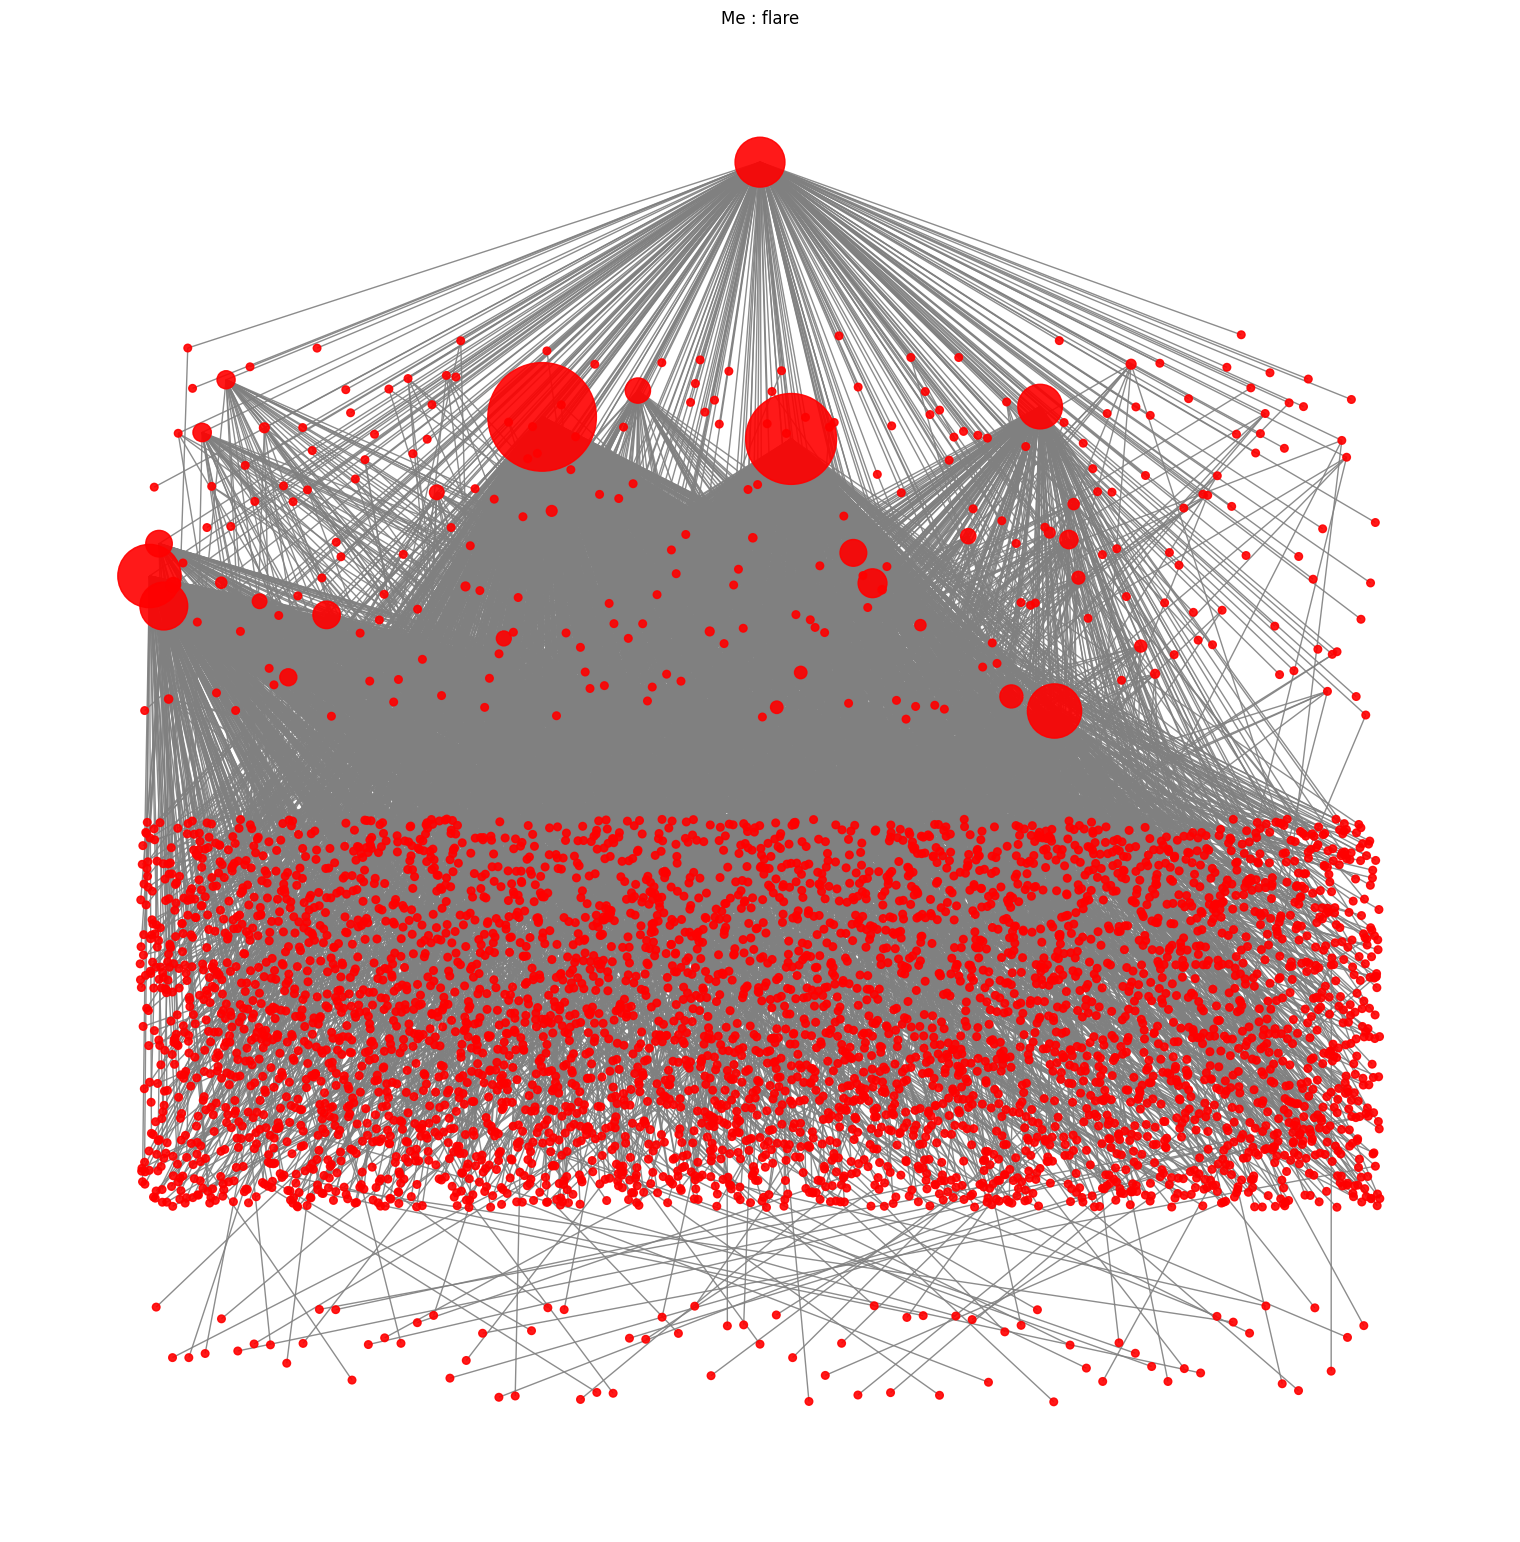

In [25]:
acceptedColours = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Grays', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r', 'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r', 'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r', 'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r', 'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r', 'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r', 'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'crest', 'crest_r', 'cubehelix', 'cubehelix_r', 'flag', 'flag_r', 'flare', 'flare_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_grey', 'gist_heat', 'gist_heat_r', 'gist_ncar', 'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gist_yerg', 'gnuplot', 'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'grey', 'hot', 'hot_r', 'hsv', 'hsv_r', 'icefire', 'icefire_r', 'inferno', 'inferno_r', 'jet', 'jet_r', 'magma', 'magma_r', 'mako', 'mako_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma', 'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'rocket', 'rocket_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer', 'summer_r', 'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r', 'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'vlag', 'vlag_r', 'winter', 'winter_r']

# for x in range(20):
adj_matrix_co_occurrence_shortest_path("love", adj_matrix_combined, "flare", "Me")
# for x in range(20):    
    # adj_matrix_co_occurrence_shortest_path("love", adj_matrix_them, "bwr_r", "Hazel")
# for color in acceptedColours:
#     adj_matrix_co_occurrence_shortest_path("love", adj_matrix_me, color, "Me")
    
# for color in acceptedColours:
    # adj_matrix_co_occurrence_shortest_path("love", adj_matrix_them, color, "Hazel")

    


In [85]:
def adj_matrix_dendogram():
    # Compute the linkage matrix for hierarchical clustering
    linkage_matrix = linkage(adj_matrix, method='ward')

    # Plot the dendrogram
    plt.figure(figsize=(10, 8))
    dendrogram(linkage_matrix, labels=adj_matrix.index, leaf_rotation=90, leaf_font_size=10)
    plt.title("Dendrogram of Word Clusters")
    plt.xlabel("Words")
    plt.ylabel("Distance")
    plt.show()

In [86]:
def adj_matrix_co_occurrence():
    # Plot the co-occurrence matrix
    
    # Create a graph using networkx
    G = nx.Graph()

    # Add nodes
    for word in adj_matrix.index:
        G.add_node(word)

    # Add edges
    for word1 in adj_matrix.index:
        for word2 in adj_matrix.columns:
            if word1 != word2 and adj_matrix.at[word1, word2] > 0:
                G.add_edge(word1, word2, weight=adj_matrix.at[word1, word2])


    degrees = dict(G.degree(G.nodes()))
    
    node_size = [degrees[n] * 10 for n in G.nodes()]
   
   
    comp = girvan_newman(G)
    threshold = 20  # Stop when number of communities is greater than threshold
    # Print intermediate results to debug
    for communities in comp:
        print(f"Number of communities: {len(communities)}")
        if len(communities) > threshold:
            clusters = communities
            break
    if clusters is None:
        clusters = [set(G.nodes())]
        
    # Assign colors to clusters
    color_map = {}
    colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'pink', 'brown', 'grey', 'cyan']
    for i, cluster in enumerate(clusters):
        for node in cluster:
            color_map[node] = colors[i % len(colors)]

    # Draw the graph with Kamada-Kawai layout and color-coded clusters
    plt.figure(figsize=(10, 8))
    pos = nx.kamada_kawai_layout(G)
    
    for node, degree in degrees.items():
        if degree == 0:
            pos[node] = (np.random.uniform(-1, 1), np.random.uniform(-1, 1))  # Random position away from the center

    node_colors = [color_map[node] for node in G.nodes()]
    nx.draw(G, pos, with_labels=True, font_size=5, node_size=80, node_color=node_colors, edge_color='grey', alpha=0.5)
    plt.title("Word Co-occurrence Graph - Kamada-Kawai Layout with Clusters")
    plt.show()

In [161]:

def adj_matrix_co_occurrence_shortest_path_other(end_node, adj_matrix, colorPallette):
    # Plot the co-occurrence matrix
    
    # Create a graph using networkx
    G = nx.Graph()
    G2 = nx.Graph()

    # Add nodes
    for word in adj_matrix.index:
        G.add_node(word)
        G2.add_node(word)
        
        # Add edges
    for word1 in adj_matrix.index:
        for word2 in adj_matrix.columns:
            if word1 != word2 and adj_matrix.at[word1, word2] > 0:
                if word1 == end_node or word2 == end_node:
                    print("Added edge between" + word1 + " and " + word2)
                G2.add_edge(word1, word2, weight=adj_matrix.at[word1, word2])

    # Add edges
    for word in adj_matrix.index:
        if nx.has_path(G2, source=word, target=end_node):
            shortest_path = nx.shortest_path(G2, source=word, target=end_node)
            print(f"Shortest path from {word} to {end_node}: {shortest_path}")
            
            for i in range(len(shortest_path)-1):
                print(f"Adding edge between {shortest_path[i]} and {shortest_path[i+1]}")
                G.add_edge(shortest_path[i], shortest_path[i+1], weight=adj_matrix.at[shortest_path[i], shortest_path[i+1]])
        else:
            print(f"No path from {word} to {end_node}")

    degrees = dict(G.degree(G.nodes()))
    
    # Perform clustering using the Girvan-Newman algorithm
    comp = girvan_newman(G)
    threshold = 20  # Stop when number of communities is greater than threshold
    # Print intermediate results to debug
    for communities in comp:
        # print(f"Number of communities: {len(communities)}")
        if len(communities) > threshold:
            clusters = communities
            break
    if clusters is None:
        clusters = [set(G.nodes())]

    # Create figure and subplots
    fig, axes = plt.subplots(1, 2, figsize=(20, 20))  # 1 row, 2 columns of subplots

    # Plot 1: Kamada-Kawai layout
    ax1 = axes[0]
    ax1.set_facecolor('lightgrey')
    ax1.set_title("Word Co-occurrence Graph - Kamada-Kawai Layout")
    pos1 = nx.kamada_kawai_layout(G)

    for node, degree in degrees.items():
        if degree == 0:
            G.remove_node(node)
        pos1[node] = (np.random.uniform(-1, 1), np.random.uniform(-1, 1))
        if node == end_node:
            pos1[node] = (0, 1.2)
            
        # Assign colors to clusters
    color_map = {}
    cmap = plt.get_cmap(colorPallette)
    colors = [cmap(i) for i in range(len(clusters))]
    for i, cluster in enumerate(clusters):
        for node in cluster:
            color_map[node] = colors[i % len(colors)]
            
    node_colors = [color_map[node] for node in G.nodes()]
    
    edge_opacity = 0.5
    edge_colors = [
        mcolors.to_rgba_array([color_map[u], color_map[v]]).mean(axis=0)
        for u, v in G.edges()
    ]
    edge_colors = [(r, g, b, edge_opacity) for r, g, b, _ in edge_colors]

    degrees = dict(G.degree(G.nodes()))
    node_size = [degrees[n] * 10 for n in G.nodes()]
    nx.draw(
        G,
        pos1,
        ax=ax1,  # Specify which axes to draw on
        with_labels=False,
        font_size=5,
        node_size=node_size,
        node_color=node_colors,
        edge_color='grey',
        alpha=0.9,
    )

    # Plot 2: Spring layout
    ax2 = axes[1]
    ax2.set_facecolor('lightgrey')
    ax2.set_title("Word Co-occurrence Graph - Spring Layout")
    pos2 = nx.spring_layout(G)
    nx.draw(
        G,
        pos2,
        ax=ax2,  # Specify which axes to draw on
        with_labels=False,
        font_size=5,
        node_size=30,
        node_color=[color_map[node] for node in G.nodes()],
        edge_color='grey',
        alpha=0.9,
    )

    # Adjust layout and show plot
    plt.tight_layout()
    plt.show()

Added edge betweenyou and love
Added edge betweendid and love
Added edge betweeni and love
Added edge betweenand and love
Added edge betweenill and love
Added edge betweenin and love
Added edge betweena and love
Added edge betweengirl and love
Added edge betweenyeah and love
Added edge betweenif and love
Added edge betweenim and love
Added edge betweenthat and love
Added edge betweenplease and love
Added edge betweenget and love
Added edge betweennot and love
Added edge betweenthats and love
Added edge betweenbut and love
Added edge betweenloved and love
Added edge betweento and love
Added edge betweenthen and love
Added edge betweenthe and love
Added edge betweenyour and love
Added edge betweenreally and love
Added edge betweenmiss and love
Added edge betweensee and love
Added edge betweenthink and love
Added edge betweenme and love
Added edge betweenthough and love
Added edge betweenhe and love
Added edge betweenso and love
Added edge betweenit and love
Added edge betweenmuch and lov

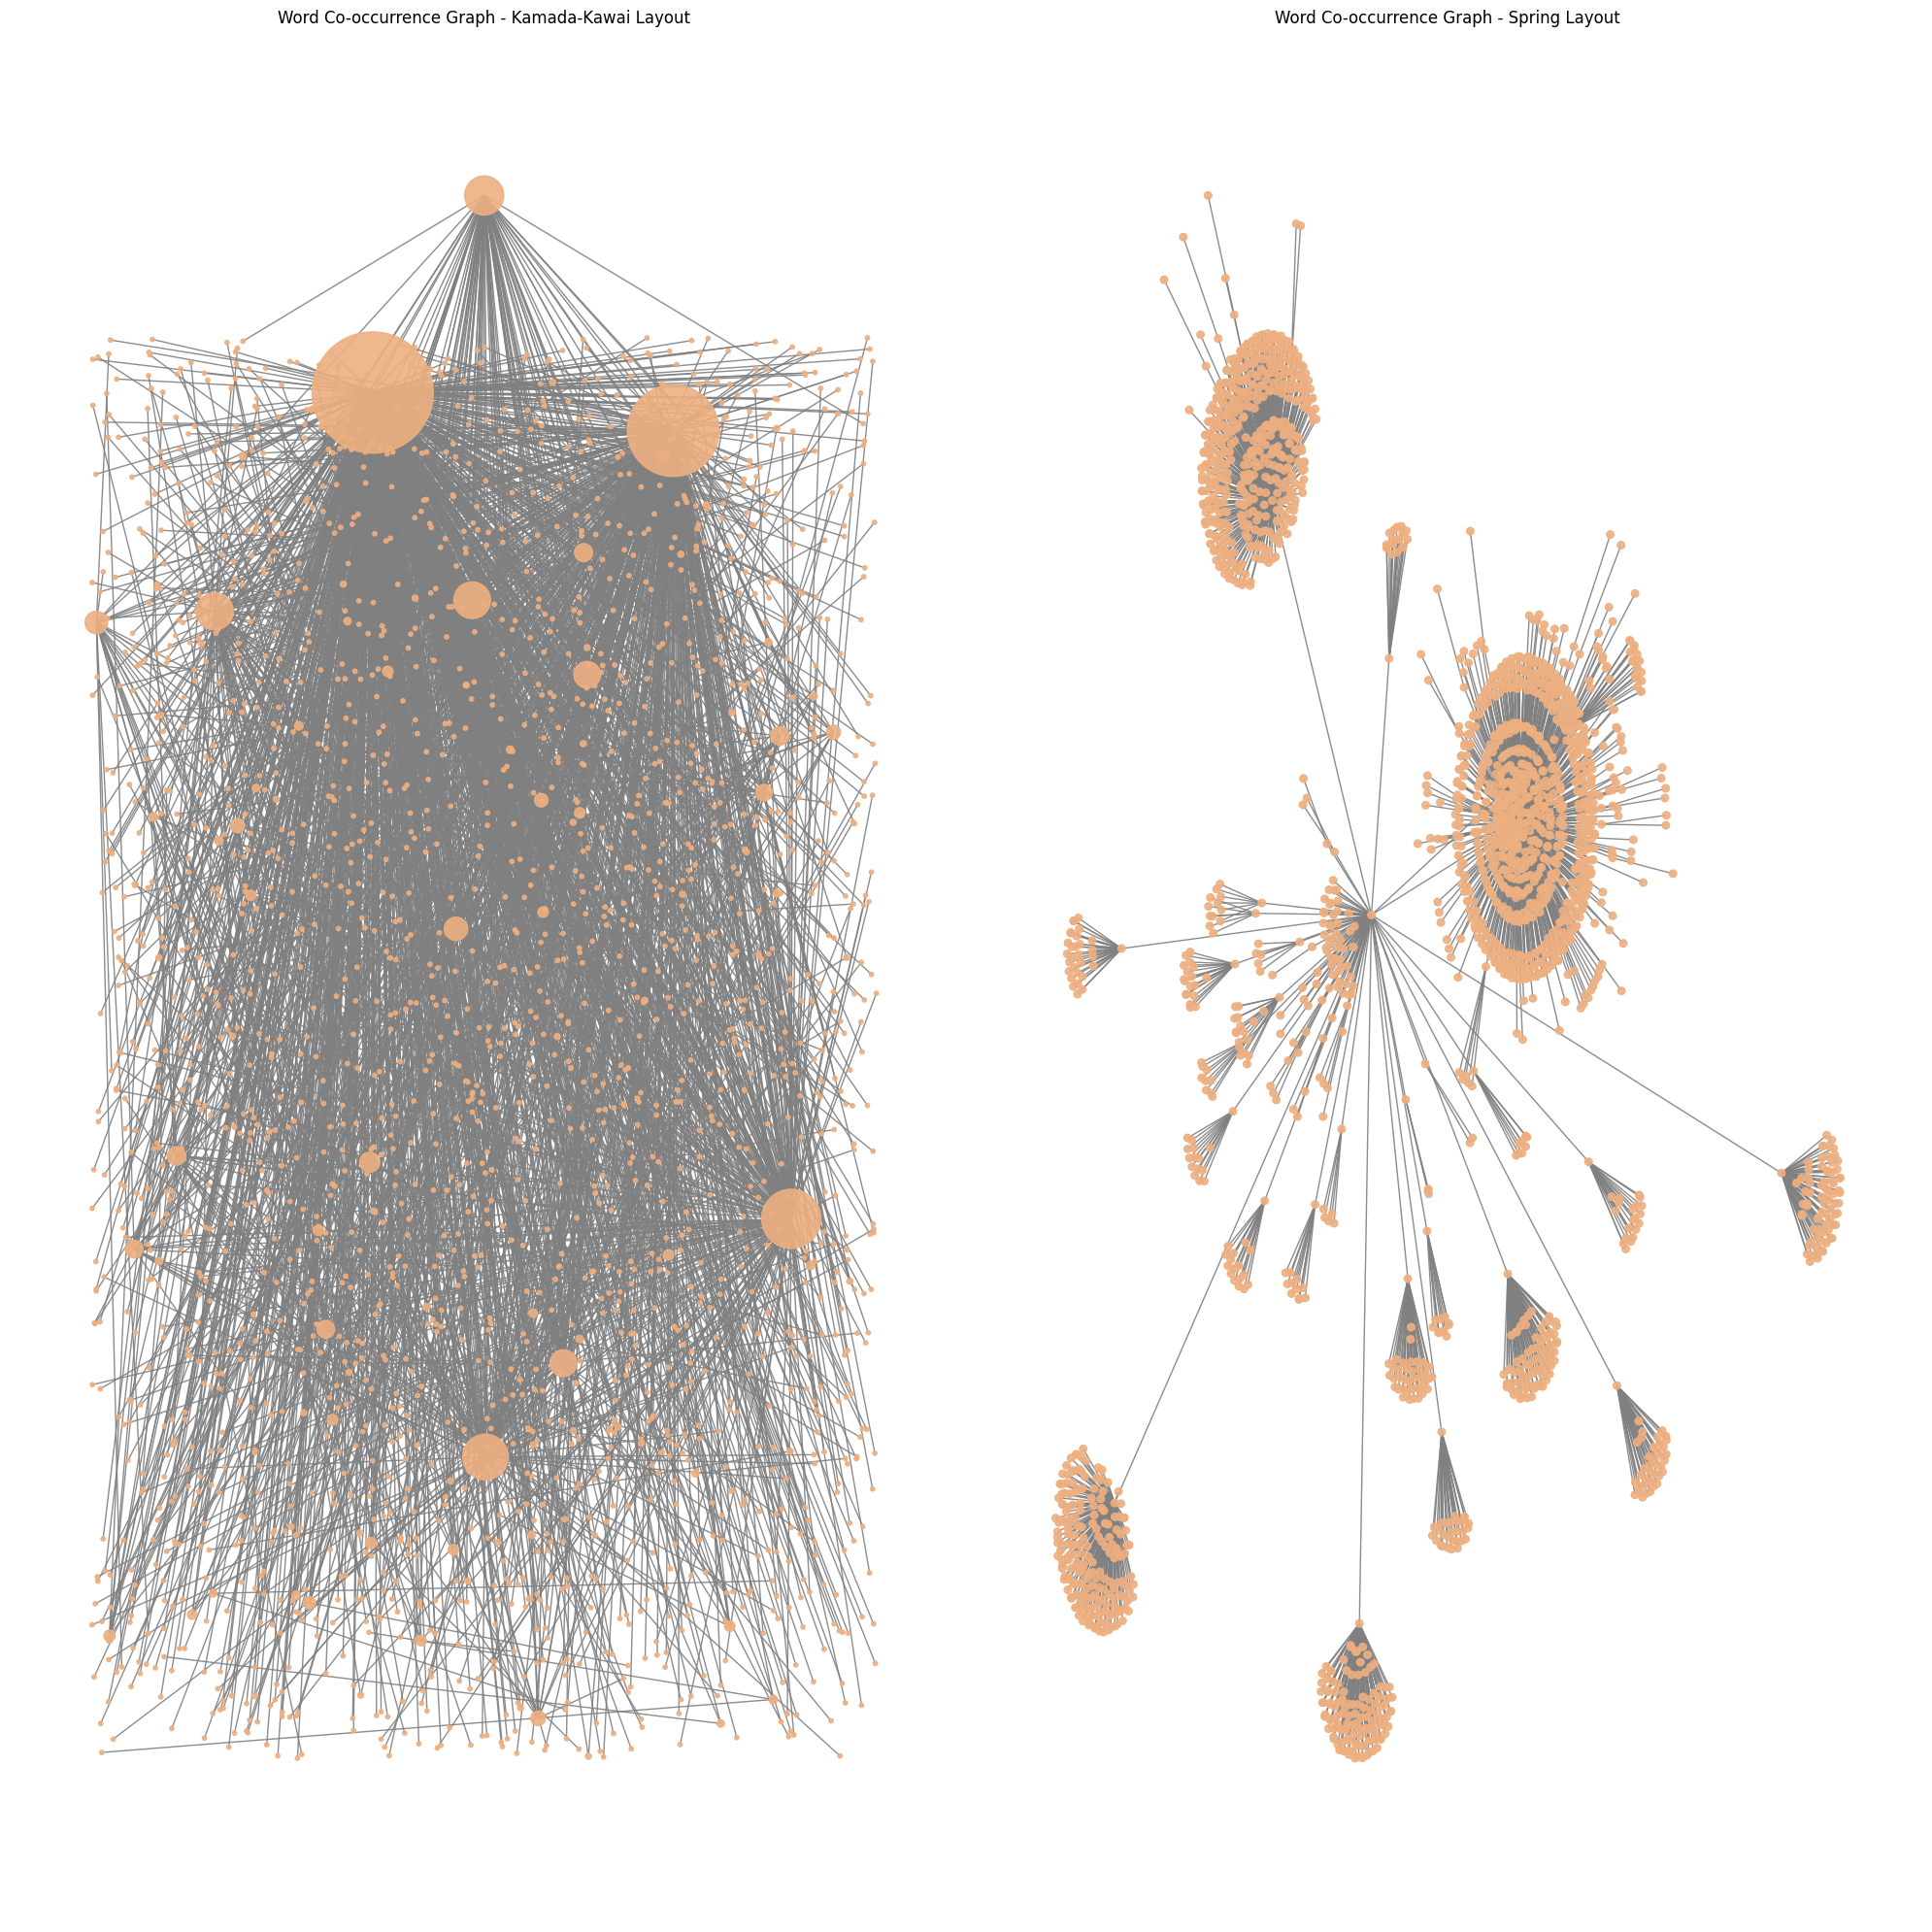

In [162]:
adj_matrix_co_occurrence_shortest_path_other("love", adj_matrix_me, "flare")